# Fitting

This notebook is intended to fit the data associated with human CRISPRi activity scores to train a linear regression model to.

The data used is that from the following paper:

[Compact and highly active next-generation libraries for CRISPR-mediated gene repression and activation](https://elifesciences.org/articles/19760)

__Authors__: Anthony Hein, Briana Macedo

---

## Imports and Configuration

In [116]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.gridspec as gridspec

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix

import re

In [121]:
np.random.seed(0)
plt.rcParams.update({'font.size': 16})

---

## Dataframe to Array

In [3]:
features_raw = pd.read_csv('features_binned.csv')
features_raw.head()

,Unnamed: 0,+ve strand,pos_-27_A,pos_-27_C,pos_-27_G,pos_-27_T,pos_-26_A,pos_-26_C,pos_-26_G,pos_-26_T,...,AG_comp_0.9,AG_comp_1.0,length_18,length_19,length_20,length_21,length_22,length_23,length_24,length_25
0,0,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
1,1,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
2,2,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
3,3,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
4,4,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False


In [4]:
scores_arr = np.array(pd.read_csv('features.csv')['score'])
scores_arr

array([0.01932036, 0.34889211, 0.91240883, ..., 0.215028  , 1.17072619,
       0.57770586])

In [5]:
features_df = features_raw.drop(columns=['Unnamed: 0'])
features_arr = np.array(features_df)
features_arr

array([[1, 0, 0, ..., False, False, False],
       [1, 0, 0, ..., False, False, False],
       [1, 0, 0, ..., False, False, False],
       ...,
       [0, 0, 0, ..., False, False, False],
       [0, 0, 0, ..., False, False, False],
       [0, 0, 0, ..., False, False, False]], dtype=object)

---

## Standardize Data to N(0, 1)

In [6]:
scaler = StandardScaler()
scaler.fit(features_arr)
features_arr_std = scaler.transform(features_arr)

In [7]:
### CHECK ###
idxs = np.random.choice(features_arr_std.shape[1], size=5)
for idx in idxs:
    assert abs(np.mean(features_arr_std[:, idx])) < 1e-2
    assert abs(np.std(features_arr_std[:, idx]) - 1) < 1e-2

---

## Create K=5 Folds

In [8]:
Xs_train = []
Ys_train = []

Xs_test = []
Ys_test = []

splits = []

folds = KFold(n_splits=5, shuffle = True)

for train_index, test_index in folds.split(features_arr_std):

    Xs_train.append(features_arr_std[train_index])
    Ys_train.append(scores_arr[train_index])
    
    Xs_test.append(features_arr_std[test_index])
    Ys_test.append(scores_arr[test_index])
    
    splits.append( (train_index, test_index) )

---

## Elastic Net

In [9]:
models = []
coefs = []

In [10]:
# train K=5 models
for i in range(len(splits)):
    model = ElasticNetCV(cv=splits[i:i+1], random_state=0, max_iter=100000)
    model.fit(features_arr_std, scores_arr)
    
    coefs.append(model.coef_)
    models.append(model)

In [11]:
# performance metrics
rs_squared = []
rs = []
accuracies = []
roc_aucs = []

for model in models:
    
    r_squared = model.score(features_arr_std, scores_arr)
    r = np.sqrt(r_squared)

    preds_arr = model.predict(features_arr_std)
    preds_bin = preds_arr > 0.75
    scores_bin = scores_arr > 0.75
    incorrect = np.logical_xor(preds_bin, scores_bin)
    accuracy = np.mean(np.logical_not(incorrect))
    
    roc_auc = roc_auc_score(scores_bin, preds_arr)
    
    rs_squared.append(r_squared)
    rs.append(r)
    accuracies.append(accuracy)
    roc_aucs.append(roc_auc_score(scores_bin, preds_arr))

In [12]:
tn, fp, fn, tp = confusion_matrix(scores_bin, preds_bin).ravel()
(tn, fp, fn, tp)

(11831, 355, 3576, 604)

In [13]:
# save performance to csv
data = {
    'R Squared':rs_squared,
    'R': rs,
    'Accuracy': accuracies,
    'ROC AUC': roc_aucs
} 
   
df = pd.DataFrame(data) 
df.to_csv("elastic_net_performance.csv")

In [14]:
# find coefficients

mean_arr = np.mean(np.array(coefs), axis=0)
min_arr = np.min(np.array(coefs), axis=0)
max_arr = np.max(np.array(coefs), axis=0)

tpl_arr = np.stack([mean_arr, min_arr, max_arr])

In [15]:
# save coefficients to numpy object
np.save("coef_elastic.npy", tpl_arr)

---

## Figure 1B

In [16]:
min(roc_aucs), max(roc_aucs)

(0.7557628783363448, 0.7598881118579089)

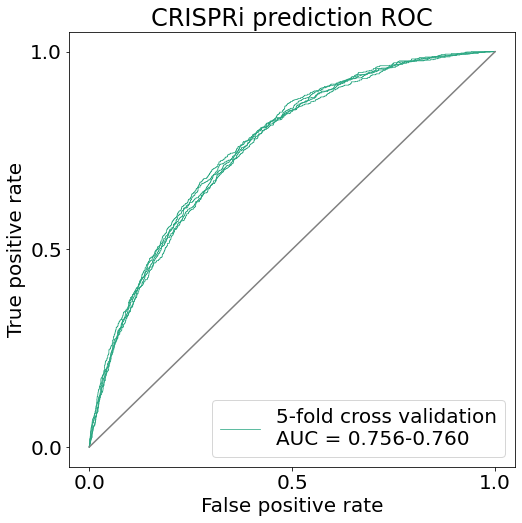

In [17]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)

for i in range(len(models)):
    
    test_idxs = splits[i][1]

    preds_arr = models[i].predict(features_arr_std[test_idxs])
    scores_bin = scores_arr[test_idxs] > 0.75
    
    fpr, tpr, thresholds = metrics.roc_curve(scores_bin, preds_arr)
    ax1.plot(fpr, tpr, lw=0.75, color="#2AA782", label='5-fold cross validation\nAUC = 0.756-0.760')
    
    if i == 0:
        ax1.legend()
    
ax1.plot(np.array([0,1]), np.array([0,1]), color="gray")
ax1.set_xlabel("False positive rate")
ax1.set_ylabel("True positive rate")
ax1.set_xticks(np.array([0, 0.5, 1]))
ax1.set_yticks(np.array([0, 0.5, 1]))
ax1.set_title("CRISPRi prediction ROC")
plt.show()

---

## Figure 1C

In [18]:
cols = features_df.columns

def find_comp(string, nucl):
    prog = re.compile('^' + nucl + '_comp')
    result = prog.match(string)
    return bool(result)

def find_dimer_pos(string):
    prog = re.compile('pos_-[0-9]+_[A-Z][A-Z]$')
    result = prog.match(string)
    return bool(result)

def find_nucl_pos(string):
    prog = re.compile('pos_-[0-9]+_[A-Z]$')
    result = prog.match(string)
    return bool(result)

def find_contribution(model, idxs):
    contr = np.sum(features_arr_std[:, idxs] * model.coef_[idxs], axis=1)
    ile_sub_contr = np.percentile(contr, 95) - np.percentile(contr, 5)
    return ile_sub_contr

In [19]:
nucls = ['A', 'C', 'G', 'T']
contrs = []
    
for model in models:
    
    comp_contr = np.sum([
        find_contribution(model, [find_comp(col, nucl) for col in cols]) for nucl in nucls
    ])
    
    TSS_contr = find_contribution(model, ['dist' in col for col in cols])
        
    run_contr = np.sum([
        find_contribution(model, ['longest_' + nucl in col for col in cols]) for nucl in nucls
    ])
    
    strand_contr = find_contribution(model, ['+ve' in col for col in cols])
    
    len_contr = find_contribution(model, ['length' in col for col in cols])
    
    nucl_contr = find_contribution(model, [find_nucl_pos(col) for col in cols])
    
    dimer_contr = find_contribution(model, [find_dimer_pos(col) for col in cols])
    
    contr = [
        comp_contr, TSS_contr, run_contr, strand_contr, 
        len_contr, nucl_contr, dimer_contr
    ]
    
    contrs.append(contr)

In [20]:
avg_contrs = np.mean(contrs, axis=0)
sorted_indices = np.argsort(avg_contrs)

avg_contrs = avg_contrs[sorted_indices]

for i in range(len(contrs)):
    contrs[i] = np.array(contrs[i])[sorted_indices]
    
labels = np.array([
    "Overall nucleotide composition",
    "Target site position relative to TSS", 
    "sgRNA nucelotide homopolymers",
    "DNA Strand Targeted",
    "sgRNA length",
    "Nucleotides at each position",
    "Nucleotide dimers at each position"
])[sorted_indices]

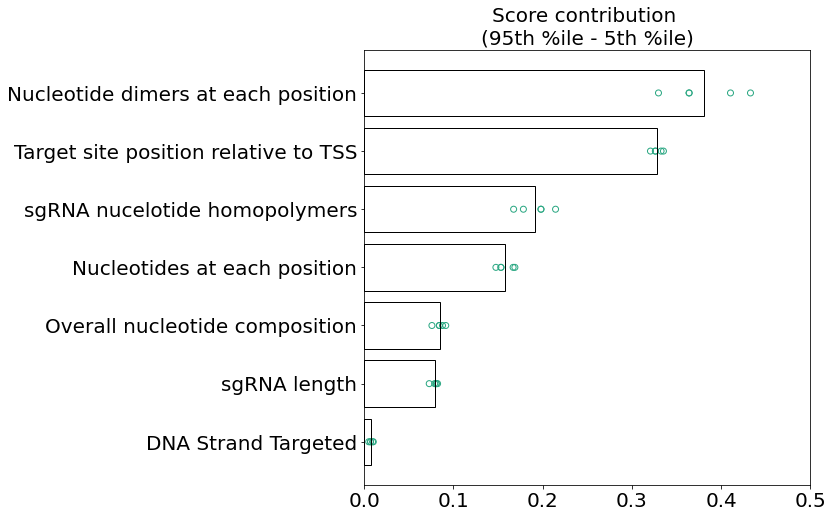

In [21]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)

for i in range(len(contrs)):
    ax1.scatter(contrs[i], np.arange(0, len(labels)), facecolors='none', edgecolors='#2AA782')

ax1.barh(labels, avg_contrs, color=(1, 1, 1, 0), edgecolor='k')
ax1.set_xlim(0, 0.5)

ax1.set_title('Score contribution \n(95th %ile - 5th %ile)', fontsize=20)
plt.show()

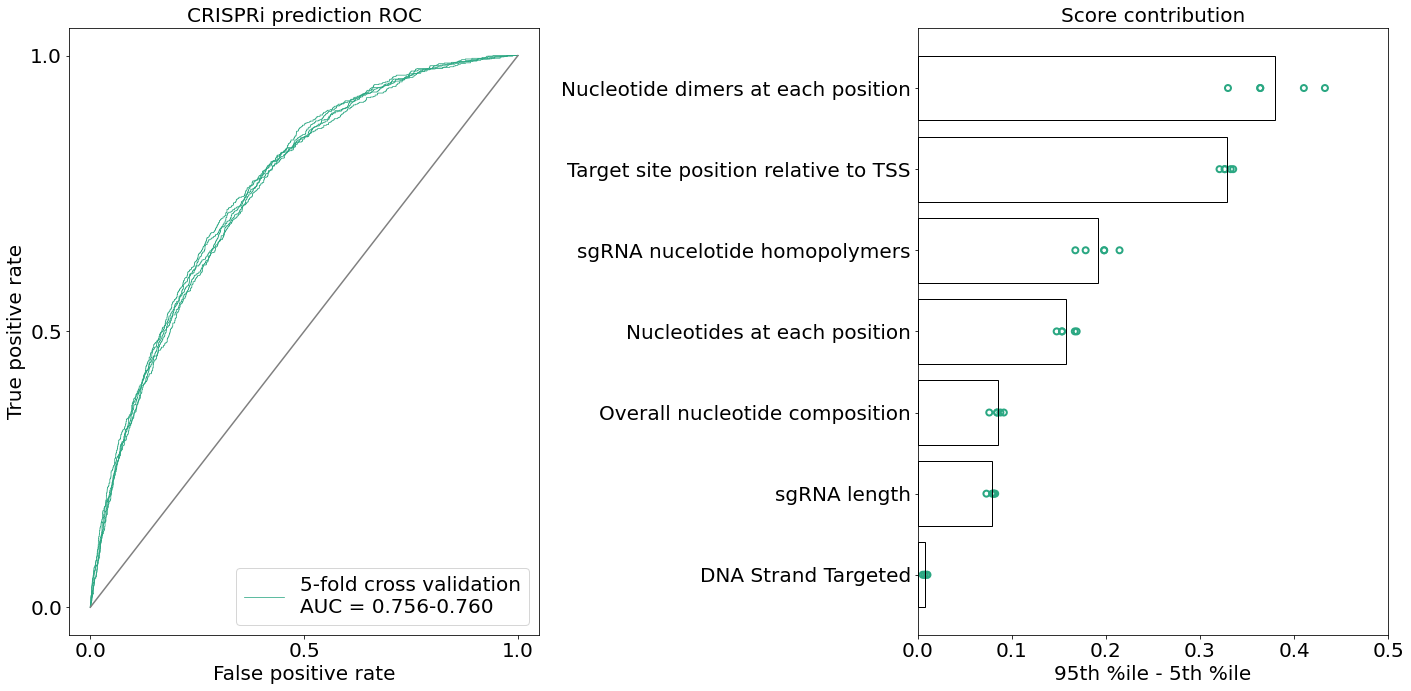

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

for i in range(len(models)):
    
    test_idxs = splits[i][1]

    preds_arr = models[i].predict(features_arr_std[test_idxs])
    scores_bin = scores_arr[test_idxs] > 0.75
    
    fpr, tpr, thresholds = metrics.roc_curve(scores_bin, preds_arr)
    axs[0].plot(fpr, tpr, lw=0.75, color="#2AA782", label='5-fold cross validation\nAUC = 0.756-0.760')
    
    if i == 0:
        axs[0].legend()
    
axs[0].plot(np.array([0,1]), np.array([0,1]), color="gray")
axs[0].set_xlabel("False positive rate")
axs[0].set_ylabel("True positive rate")
axs[0].set_xticks(np.array([0, 0.5, 1]))
axs[0].set_yticks(np.array([0, 0.5, 1]))
axs[0].set_title("CRISPRi prediction ROC", fontsize=20)

for i in range(len(contrs)):
    axs[1].scatter(contrs[i], np.arange(0, len(labels)), lw=2, facecolors='none', edgecolors='#2AA782')

axs[1].barh(labels, avg_contrs, color=(1, 1, 1, 0), edgecolor='k')
axs[1].set_xlim(0, 0.5)

axs[1].set_title('Score contribution', fontsize=20)
axs[1].set_xlabel("95th %ile - 5th %ile")

fig.tight_layout()
plt.show()

---

## TODO: Figure 1D

### (Top)

In [97]:
preds_ls = []
actuals_ls = []

for i in range(len(models)):
    
    test_idxs = splits[i][1]

    preds_arr = models[i].predict(features_arr_std[test_idxs])
    preds_ls.extend(preds_arr)
    actuals_ls.extend(scores_arr[test_idxs])
    
# preds_scores = np.mean(preds_ls, axis=0)

In [98]:
sorted_indices = np.argsort(preds_scores)

sorted_preds_scores = preds_scores[sorted_indices]
sorted_actual_scores = scores_arr[sorted_indices]

In [99]:
intervals = []
for prediction in sorted_preds_scores:
    intervals.append((prediction - 0.25, prediction + 0.25))

intervals = np.array(intervals)

In [100]:
intervals_idxs = []
for interval in intervals:
    intervals_idxs.append(
        np.logical_and(sorted_preds_scores > interval[0], sorted_preds_scores < interval[1])
    )
    
intervals_idxs = np.array(intervals_idxs)

In [101]:
ile10 = []
ile25 = []
ile50 = []
ile75 = []
ile90 = []

for idxs in intervals_idxs:
    ls = sorted_actual_scores[idxs]
    ile10.append(np.percentile(ls, 10))
    ile25.append(np.percentile(ls, 25))
    ile50.append(np.percentile(ls, 50))
    ile75.append(np.percentile(ls, 75))
    ile90.append(np.percentile(ls, 90))

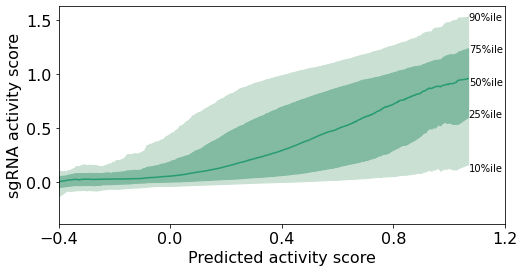

In [122]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

ax.set_xlabel("Predicted activity score")
ax.set_ylabel("sgRNA activity score")

ax.set_xticks(np.array([-0.4, 0.0, 0.4, 0.8, 1.2]))
ax.set_xlim(-0.4, 1.2)

ax.plot(sorted_preds_scores, ile50, color="#279b73")
ax.fill_between(sorted_preds_scores, ile10, ile90, color="#c9e0d3")
ax.fill_between(sorted_preds_scores, ile25, ile75, color="#82baa2")

ax.text(1.07, 1.5, '90%ile', fontsize=10)
ax.text(1.07, 1.2, '75%ile', fontsize=10)
ax.text(1.07, 0.9, '50%ile', fontsize=10)
ax.text(1.07, 0.6, '25%ile', fontsize=10)
ax.text(1.07, 0.1, '10%ile', fontsize=10)

plt.show()

### (Bottom)

Despite our model greatly resembling that in the paper as far as we can tell from the reported statistics and above plots, there is inconsistency with Figure 1D. In particular, when we featurize CRISPRi v1, hCRISPRi v2, and hCRISPRi v2.1 libraries and predict the activity score with our model, there is no discernible difference in the distributions of the three libraries.

We provide two plots: one uses their predicted scores for v2 and v2.1 alongside our predicted scores for v1 (upon which our model was trained on) and the other uses our predicted scores for all three libraries. You will find that the former more closely resembles what is found in the paper. More explanation is provided in our writeup.

#### Part 1

In [23]:
v1_preds_ls = []

for i in range(len(models)):

    v1_preds_arr = models[i].predict(features_arr_std)
    v1_preds_ls.append(v1_preds_arr)
    
v1_scores = np.mean(v1_preds_ls, axis=0)

In [24]:
v2_df = pd.read_csv('hCRISPRi_Library_v2.csv')
v2_df.head()

,sgID,gene,transcript,protospacer sequence,selection rank,predicted score,empirical score,off-target stringency,CRISPRi-v2.1 predicted score,Sublibrary,Sublibrary half
0,A1BG_-_58858617.23-P1,A1BG,P1,GGAGACCCAGCGCTAACCAG,1.0,1.008816,NaN,0,0.685071,h3,Top5
1,A1BG_-_58858788.23-P1,A1BG,P1,GGGGCACCCAGGAGCGGTAG,2.0,0.901176,NaN,0,0.782793,h3,Top5
2,A1BG_+_58858964.23-P1,A1BG,P1,GCTCCGGGCGACGTGGAGTG,3.0,0.836188,NaN,0,0.870837,h3,Top5
3,A1BG_-_58858630.23-P1,A1BG,P1,GAACCAGGGGTGCCCAAGGG,4.0,0.827551,NaN,0,0.590668,h3,Top5
4,A1BG_+_58858549.23-P1,A1BG,P1,GGCGAGGAACCGCCCAGCAA,5.0,0.775395,NaN,0,0.492280,h3,Top5


In [25]:
v2_scores = v2_df['CRISPRi-v2.1 predicted score']
v2_scores.head()

0    0.685071
1    0.782793
2    0.870837
3    0.590668
4    0.492280
Name: CRISPRi-v2.1 predicted score, dtype: float64

In [26]:
v2_scores.shape

(209070,)

In [27]:
v2_scores = v2_scores.dropna()
v2_scores.shape

(205280,)

In [28]:
v2p1_df = pd.read_csv('hCRISPRi_Library_v2.1.csv')
v2p1_df.head()

,sgID,gene,transcript,protospacer sequence,selection rank,predicted score,empirical score,off-target stringency,Sublibrary half
0,A1BG_+_58858964.23-P1,A1BG,P1,GCTCCGGGCGACGTGGAGTG,1,0.870837,NaN,0,Top5
1,A1BG_-_58858788.23-P1,A1BG,P1,GGGGCACCCAGGAGCGGTAG,2,0.782793,NaN,0,Top5
2,A1BG_-_58858991.23-P1,A1BG,P1,GTCCACGTCGCCCGGAGCTG,3,0.722963,NaN,0,Top5
3,A1BG_-_58858950.23-P1,A1BG,P1,GGCAGCGCAGGACGGCATCT,4,0.706643,NaN,0,Top5
4,A1BG_-_58858915.23-P1,A1BG,P1,GAGCAGCTCGAAGGTGACGT,5,0.700359,NaN,0,Top5


In [29]:
v2p1_scores = v2p1_df['predicted score']
v2p1_scores.head()

0    0.870837
1    0.782793
2    0.722963
3    0.706643
4    0.700359
Name: predicted score, dtype: float64

In [30]:
v2p1_scores.shape

(205280,)

In [31]:
v2p1_scores = v2p1_scores.dropna()
v2p1_scores.shape

(199339,)

In [32]:
# the tick marks will be in thousands
def thousands(x, pos):
    return int(x / 1e3)

formatter = FuncFormatter(thousands)

In [33]:
preds_ls = []

for i in range(len(models)):

    preds_arr = models[i].predict(features_arr_std)
    preds_ls.append(preds_arr)
    
library_v1_scores = np.mean(preds_ls, axis=0)

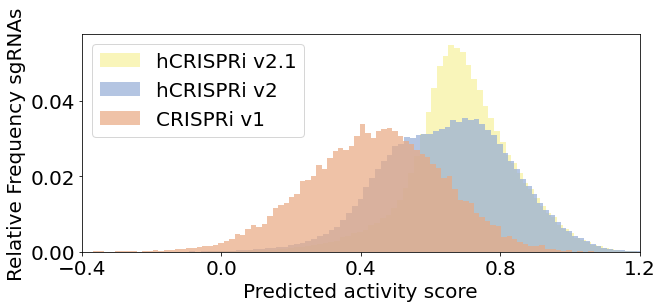

In [34]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)

ax.set_xlabel("Predicted activity score")
ax.set_ylabel("Relative Frequency sgRNAs")

# ax.yaxis.set_major_formatter(formatter)
# ax.set_yticks(np.array([0, 0., 10e3]))

ax.set_xticks(np.array([-0.4, 0.0, 0.4, 0.8, 1.2]))
ax.set_xlim(-0.4, 1.2)

ax.hist(v2p1_scores, bins=100, color='#f7f29d', alpha=0.7, 
        weights=np.zeros_like(v2p1_scores) + 1. / v2p1_scores.size,
        label="hCRISPRi v2.1")

ax.hist(v2_scores, bins=100, color='#94add6', alpha=0.7, 
        weights=np.zeros_like(v2_scores) + 1. / v2_scores.size, 
        label="hCRISPRi v2")

ax.hist(v1_scores, bins=100, color='#e9a982', alpha=0.7, 
        weights=np.zeros_like(v1_scores) + 1. / v1_scores.size, 
        label="CRISPRi v1")

ax.legend()

plt.show()

---

#### Part 2

In [35]:
v2_df = pd.read_csv("features_hCRISPRi_v2_binned.csv").drop(columns=['Unnamed: 0'])
v2_df

,+ve strand,pos_-27_A,pos_-27_C,pos_-27_G,pos_-27_T,pos_-26_A,pos_-26_C,pos_-26_G,pos_-26_T,pos_-25_A,...,AG_comp_0.9,AG_comp_1.0,length_18,length_19,length_20,length_21,length_22,length_23,length_24,length_25
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
1,1,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
2,1,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
3,1,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155909,1,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
155910,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
155911,1,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
155912,1,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False


In [36]:
v2_arr = np.array(v2_df)
v2_arr

array([[0, 0, 0, ..., False, False, False],
       [1, 0, 0, ..., False, False, False],
       [1, 0, 0, ..., False, False, False],
       ...,
       [1, 0, 0, ..., False, False, False],
       [1, 0, 0, ..., False, False, False],
       [1, 0, 0, ..., False, False, False]], dtype=object)

In [37]:
scaler = StandardScaler()
scaler.fit(v2_arr)
v2_arr_std = scaler.transform(v2_arr)

In [38]:
v2_preds_ls = []

for i in range(len(models)):

    v2_preds_arr = models[i].predict(v2_arr_std)
    v2_preds_ls.append(v2_preds_arr)
    
v2_scores_1 = np.mean(v2_preds_ls, axis=0)

In [39]:
v2p1_df = pd.read_csv("features_hCRISPRi_v2.1_binned.csv").drop(columns=['Unnamed: 0'])
v2p1_df

,+ve strand,pos_-27_A,pos_-27_C,pos_-27_G,pos_-27_T,pos_-26_A,pos_-26_C,pos_-26_G,pos_-26_T,pos_-25_A,...,AG_comp_0.9,AG_comp_1.0,length_18,length_19,length_20,length_21,length_22,length_23,length_24,length_25
0,1,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
2,1,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
3,1,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
4,1,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152316,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
152317,1,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
152318,1,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
152319,1,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False


In [40]:
v2p1_arr = np.array(v2p1_df)
v2p1_arr

array([[1, 0, 0, ..., False, False, False],
       [0, 0, 0, ..., False, False, False],
       [1, 0, 0, ..., False, False, False],
       ...,
       [1, 0, 0, ..., False, False, False],
       [1, 0, 0, ..., False, False, False],
       [0, 0, 0, ..., False, False, False]], dtype=object)

In [41]:
scaler = StandardScaler()
scaler.fit(v2p1_arr)
v2p1_arr_std = scaler.transform(v2p1_arr)

In [42]:
v2p1_preds_ls = []

for i in range(len(models)):

    v2p1_preds_arr = models[i].predict(v2p1_arr_std)
    v2p1_preds_ls.append(v2p1_preds_arr)
    
v2p1_scores_1 = np.mean(v2p1_preds_ls, axis=0)

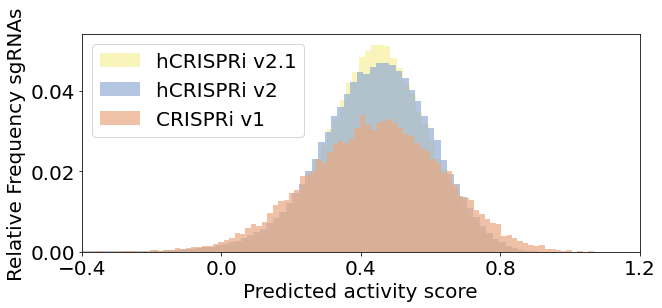

In [43]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)

ax.set_xlabel("Predicted activity score")
ax.set_ylabel("Relative Frequency sgRNAs")

# ax.yaxis.set_major_formatter(formatter)
# ax.set_yticks(np.array([0, 5e3, 10e3]))

ax.set_xticks(np.array([-0.4, 0.0, 0.4, 0.8, 1.2]))
ax.set_xlim(-0.4, 1.2)

ax.hist(v2p1_scores_1, bins=100, color='#f7f29d', alpha=0.7, 
        weights=np.zeros_like(v2p1_scores_1) + 1. / v2p1_scores_1.size, 
        label="hCRISPRi v2.1")

ax.hist(v2_scores_1, bins=100, color='#94add6', alpha=0.7, 
        weights=np.zeros_like(v2_scores_1) + 1. / v2_scores_1.size, 
        label="hCRISPRi v2")

ax.hist(v1_scores, bins=100, color='#e9a982', alpha=0.7, 
        weights=np.zeros_like(v1_scores) + 1. / v1_scores.size, 
        label="CRISPRi v1")

ax.legend()

plt.show()

---

## Top 5 sgRNA Per Gene

In [44]:
genes_and_sequences = pd.read_csv("features_w_meta.csv")
genes_and_sequences = genes_and_sequences[['gene', 'sequence']]
genes_and_sequences

,gene,sequence
0,AARS,GCGCTCTGATTGGACGGAGCG
1,AARS,GCCCCAGGATCAGGCCCCGCG
2,AARS,GGCCGCCCTCGGAGAGCTCTG
3,AARS,GACGGCGACCCTAGGAGAGGT
4,AARS,GGTGCAGCGGGCCCTTGGCGG
...,...,...
16361,ZWINT,GTAATCTTAGGGATTGTGGGA
16362,ZWINT,GTGACTTCAAAGTAATCTTA
16363,ZWINT,GTGGATGTGGGGAGCGGCGAA
16364,ZWINT,GACACCTCAGGAACCTAAGAC


In [45]:
preds_ls = []

for model in models:
    
    preds_arr = model.predict(features_arr_std)
    preds_ls.append(preds_arr)
    
preds = np.mean(preds_ls, axis=0)
preds

array([0.43170144, 0.35894592, 0.60319926, ..., 0.33951195, 0.54964239,
       0.36641294])

In [46]:
genes_and_sequences['score'] = preds
genes_and_sequences

,gene,sequence,score
0,AARS,GCGCTCTGATTGGACGGAGCG,0.431701
1,AARS,GCCCCAGGATCAGGCCCCGCG,0.358946
2,AARS,GGCCGCCCTCGGAGAGCTCTG,0.603199
3,AARS,GACGGCGACCCTAGGAGAGGT,0.679125
4,AARS,GGTGCAGCGGGCCCTTGGCGG,0.646344
...,...,...,...
16361,ZWINT,GTAATCTTAGGGATTGTGGGA,0.581252
16362,ZWINT,GTGACTTCAAAGTAATCTTA,0.547363
16363,ZWINT,GTGGATGTGGGGAGCGGCGAA,0.339512
16364,ZWINT,GACACCTCAGGAACCTAAGAC,0.549642


In [47]:
tmp = genes_and_sequences.sort_values('score', ascending=False)
tmp = tmp.groupby('gene')
tmp = tmp.head(5)
tmp = tmp.sort_values('gene')
genes_and_sequences = tmp
genes_and_sequences

,gene,sequence,score
12,AARS,GGGGACGGCGACCCTAGGAG,0.731217
7,AARS,GAGGGCGGCCTACCTCTCCT,0.734518
3,AARS,GACGGCGACCCTAGGAGAGGT,0.679125
4,AARS,GGTGCAGCGGGCCCTTGGCGG,0.646344
13,AARS,GGCCCTTGGCGGGGGACTCTG,0.713997
...,...,...,...
16359,ZWINT,GCCGGGCCTGGGAGGACCTTG,0.466656
16361,ZWINT,GTAATCTTAGGGATTGTGGGA,0.581252
16362,ZWINT,GTGACTTCAAAGTAATCTTA,0.547363
16364,ZWINT,GACACCTCAGGAACCTAAGAC,0.549642


In [48]:
val_count = pd.Series.value_counts(genes_and_sequences['gene'])
val_count[val_count < 5]

KARS    3
Name: gene, dtype: int64

In [49]:
genes_and_sequences = genes_and_sequences[genes_and_sequences['gene'] != 'KARS']
genes_and_sequences

,gene,sequence,score
12,AARS,GGGGACGGCGACCCTAGGAG,0.731217
7,AARS,GAGGGCGGCCTACCTCTCCT,0.734518
3,AARS,GACGGCGACCCTAGGAGAGGT,0.679125
4,AARS,GGTGCAGCGGGCCCTTGGCGG,0.646344
13,AARS,GGCCCTTGGCGGGGGACTCTG,0.713997
...,...,...,...
16359,ZWINT,GCCGGGCCTGGGAGGACCTTG,0.466656
16361,ZWINT,GTAATCTTAGGGATTGTGGGA,0.581252
16362,ZWINT,GTGACTTCAAAGTAATCTTA,0.547363
16364,ZWINT,GACACCTCAGGAACCTAAGAC,0.549642


In [50]:
genes_and_sequences.to_csv("top5_scores_v1.csv")

# Grouped plot

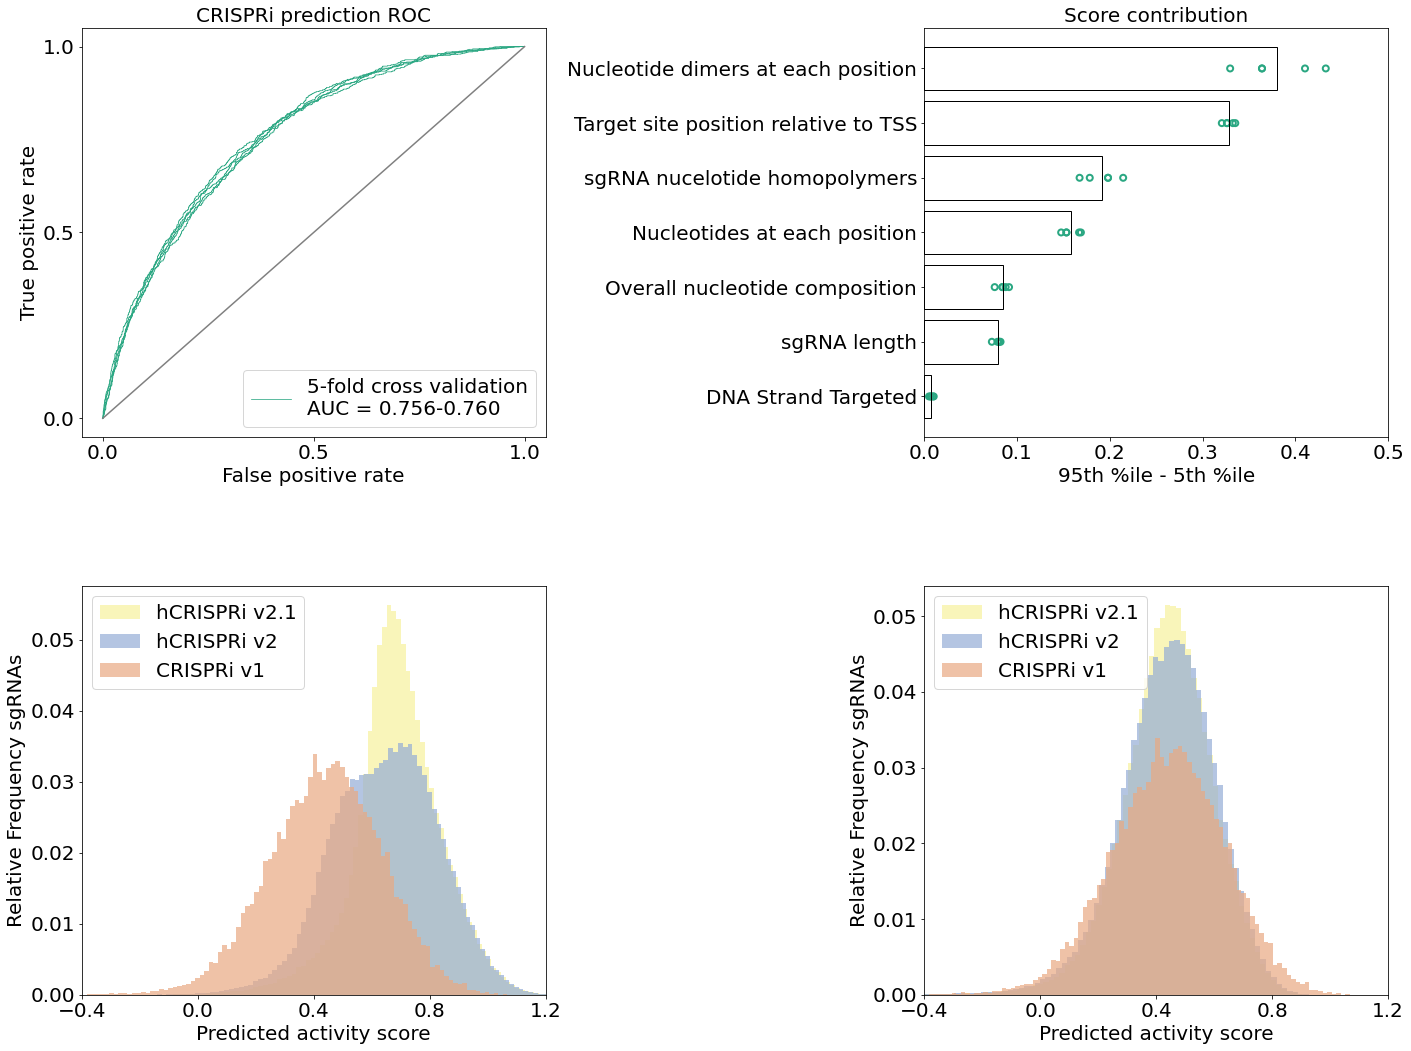

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

# ROC 
for i in range(len(models)): 
    test_idxs = splits[i][1]
    preds_arr = models[i].predict(features_arr_std[test_idxs])
    scores_bin = scores_arr[test_idxs] > 0.75
    fpr, tpr, thresholds = metrics.roc_curve(scores_bin, preds_arr)
    axs[0][0].plot(fpr, tpr, lw=0.75, color="#2AA782", label='5-fold cross validation\nAUC = 0.756-0.760')
    if i == 0:
        axs[0][0].legend()
    
axs[0][0].plot(np.array([0,1]), np.array([0,1]), color="gray")
axs[0][0].set_xlabel("False positive rate")
axs[0][0].set_ylabel("True positive rate")
axs[0][0].set_xticks(np.array([0, 0.5, 1]))
axs[0][0].set_yticks(np.array([0, 0.5, 1]))
axs[0][0].set_title("CRISPRi prediction ROC", fontsize=20)

# Feature contribution 
for i in range(len(contrs)):
    axs[0][1].scatter(contrs[i], np.arange(0, len(labels)), lw=2, facecolors='none', edgecolors='#2AA782')

axs[0][1].barh(labels, avg_contrs, color=(1, 1, 1, 0), edgecolor='k')
axs[0][1].set_xlim(0, 0.5)
axs[0][1].set_title('Score contribution', fontsize=20)
axs[0][1].set_xlabel("95th %ile - 5th %ile")

# Histogram
axs[1][0].set_xlabel("Predicted activity score")
axs[1][0].set_ylabel("Relative Frequency sgRNAs")

axs[1][0].set_xticks(np.array([-0.4, 0.0, 0.4, 0.8, 1.2]))
axs[1][0].set_xlim(-0.4, 1.2)

axs[1][0].hist(v2p1_scores, bins=100, color='#f7f29d', alpha=0.7, 
        weights=np.zeros_like(v2p1_scores) + 1. / v2p1_scores.size,
        label="hCRISPRi v2.1")

axs[1][0].hist(v2_scores, bins=100, color='#94add6', alpha=0.7, 
        weights=np.zeros_like(v2_scores) + 1. / v2_scores.size, 
        label="hCRISPRi v2")

axs[1][0].hist(v1_scores, bins=100, color='#e9a982', alpha=0.7, 
        weights=np.zeros_like(v1_scores) + 1. / v1_scores.size, 
        label="CRISPRi v1")

axs[1][0].legend()

# Histogram 
axs[1][1].set_xlabel("Predicted activity score")
axs[1][1].set_ylabel("Relative Frequency sgRNAs")
axs[1][1].set_xticks(np.array([-0.4, 0.0, 0.4, 0.8, 1.2]))
axs[1][1].set_xlim(-0.4, 1.2)

axs[1][1].hist(v2p1_scores_1, bins=100, color='#f7f29d', alpha=0.7, 
        weights=np.zeros_like(v2p1_scores_1) + 1. / v2p1_scores_1.size, 
        label="hCRISPRi v2.1")

axs[1][1].hist(v2_scores_1, bins=100, color='#94add6', alpha=0.7, 
        weights=np.zeros_like(v2_scores_1) + 1. / v2_scores_1.size, 
        label="hCRISPRi v2")

axs[1][1].hist(v1_scores, bins=100, color='#e9a982', alpha=0.7, 
        weights=np.zeros_like(v1_scores) + 1. / v1_scores.size, 
        label="CRISPRi v1")

axs[1][1].legend()

fig.tight_layout(h_pad = 5)
plt.show()

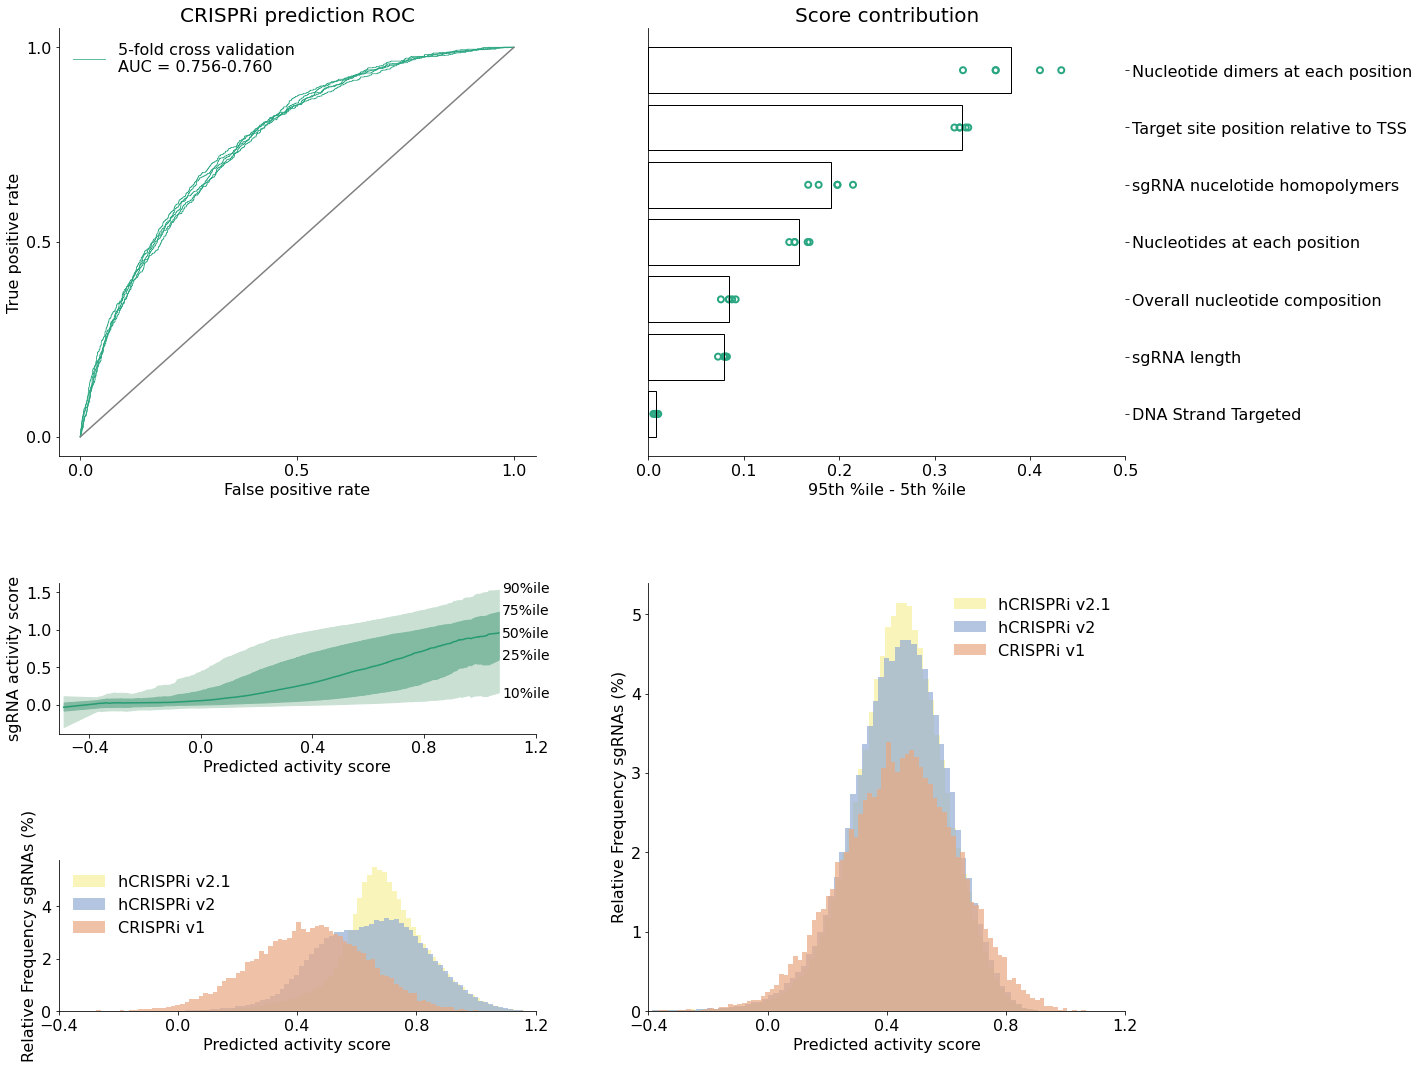

In [157]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)

# ROC 
ROC_ax = fig.add_subplot(gs[0:2, 0:2])
for i in range(len(models)): 
    test_idxs = splits[i][1]
    preds_arr = models[i].predict(features_arr_std[test_idxs])
    scores_bin = scores_arr[test_idxs] > 0.75
    fpr, tpr, thresholds = metrics.roc_curve(scores_bin, preds_arr)
    ROC_ax.plot(fpr, tpr, lw=0.75, color="#2AA782", label='5-fold cross validation\nAUC = 0.756-0.760')
    if i == 0:
        ROC_ax.legend(frameon=False)
    
ROC_ax.plot(np.array([0,1]), np.array([0,1]), color="gray")
ROC_ax.set_xlabel("False positive rate")
ROC_ax.set_ylabel("True positive rate")
ROC_ax.set_xticks(np.array([0, 0.5, 1]))
ROC_ax.set_yticks(np.array([0, 0.5, 1]))
ROC_ax.set_title("CRISPRi prediction ROC", fontsize=20)

ROC_ax.spines['top'].set_visible(False)
ROC_ax.spines['right'].set_visible(False)


# Feature contribution 
contr_ax = fig.add_subplot(gs[0:2, 2:4])

for i in range(len(contrs)):
    contr_ax.scatter(contrs[i], np.arange(0, len(labels)), lw=2, facecolors='none', edgecolors='#2AA782')

contr_ax.barh(labels, avg_contrs, color=(1, 1, 1, 0), edgecolor='k')
contr_ax.set_xlim(0, 0.5)
contr_ax.set_title('Score contribution', fontsize=20)
contr_ax.set_xlabel("95th %ile - 5th %ile")
contr_ax.yaxis.tick_right()

contr_ax.spines['top'].set_visible(False)
contr_ax.spines['right'].set_visible(False)

# Histogram
their_hist_ax = fig.add_subplot(gs[3:4, 0:2])

their_hist_ax.set_xlabel("Predicted activity score")
their_hist_ax.set_ylabel("Relative Frequency sgRNAs (%)")

their_hist_ax.set_xticks(np.array([-0.4, 0.0, 0.4, 0.8, 1.2]))
their_hist_ax.set_xlim(-0.4, 1.2)

their_hist_ax.hist(v2p1_scores, bins=100, color='#f7f29d', alpha=0.7, 
        weights=(np.zeros_like(v2p1_scores) + 1. / v2p1_scores.size) * 100,
        label="hCRISPRi v2.1")

their_hist_ax.hist(v2_scores, bins=100, color='#94add6', alpha=0.7, 
        weights=(np.zeros_like(v2_scores) + 1. / v2_scores.size) * 100, 
        label="hCRISPRi v2")

their_hist_ax.hist(v1_scores, bins=100, color='#e9a982', alpha=0.7, 
        weights=(np.zeros_like(v1_scores) + 1. / v1_scores.size) * 100, 
        label="CRISPRi v1")

their_hist_ax.spines['top'].set_visible(False)
their_hist_ax.spines['right'].set_visible(False)

their_hist_ax.legend(frameon=False)

# Histogram 
our_hist_ax = fig.add_subplot(gs[2:4, 2:4])

our_hist_ax.set_xlabel("Predicted activity score")
our_hist_ax.set_ylabel("Relative Frequency sgRNAs (%)")
our_hist_ax.set_xticks(np.array([-0.4, 0.0, 0.4, 0.8, 1.2]))
our_hist_ax.set_xlim(-0.4, 1.2)

our_hist_ax.hist(v2p1_scores_1, bins=100, color='#f7f29d', alpha=0.7, 
        weights=(np.zeros_like(v2p1_scores_1) + 1. / v2p1_scores_1.size) * 100, 
        label="hCRISPRi v2.1")

our_hist_ax.hist(v2_scores_1, bins=100, color='#94add6', alpha=0.7, 
        weights=(np.zeros_like(v2_scores_1) + 1. / v2_scores_1.size) * 100, 
        label="hCRISPRi v2")

our_hist_ax.hist(v1_scores, bins=100, color='#e9a982', alpha=0.7, 
        weights=(np.zeros_like(v1_scores) + 1. / v1_scores.size) * 100, 
        label="CRISPRi v1")

our_hist_ax.spines['top'].set_visible(False)
our_hist_ax.spines['right'].set_visible(False)

our_hist_ax.legend(frameon=False)

# Predictions vs. Actual

pred_ax = fig.add_subplot(gs[2:3, 0:2])

pred_ax.set_xlabel("Predicted activity score")
pred_ax.set_ylabel("sgRNA activity score")

pred_ax.set_xticks(np.array([-0.4, 0.0, 0.4, 0.8, 1.2]))
pred_ax.set_xlim(-0.51, 1.2)

pred_ax.set_yticks(np.array([0.0, 0.5, 1.0, 1.5]))

pred_ax.plot(sorted_preds_scores, ile50, color="#279b73")
pred_ax.fill_between(sorted_preds_scores, ile10, ile90, color="#c9e0d3")
pred_ax.fill_between(sorted_preds_scores, ile25, ile75, color="#82baa2")

pred_ax.text(1.08, 1.5, '90%ile', fontsize=14)
pred_ax.text(1.08, 1.2, '75%ile', fontsize=14)
pred_ax.text(1.08, 0.9, '50%ile', fontsize=14)
pred_ax.text(1.08, 0.6, '25%ile', fontsize=14)
pred_ax.text(1.08, 0.1, '10%ile', fontsize=14)

pred_ax.spines['top'].set_visible(False)
pred_ax.spines['right'].set_visible(False)


fig.tight_layout(h_pad = 3, w_pad = 4)
# fig.savefig("Fig1")

plt.show()


<ipython-input-159-c83f49b4d323>:117: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


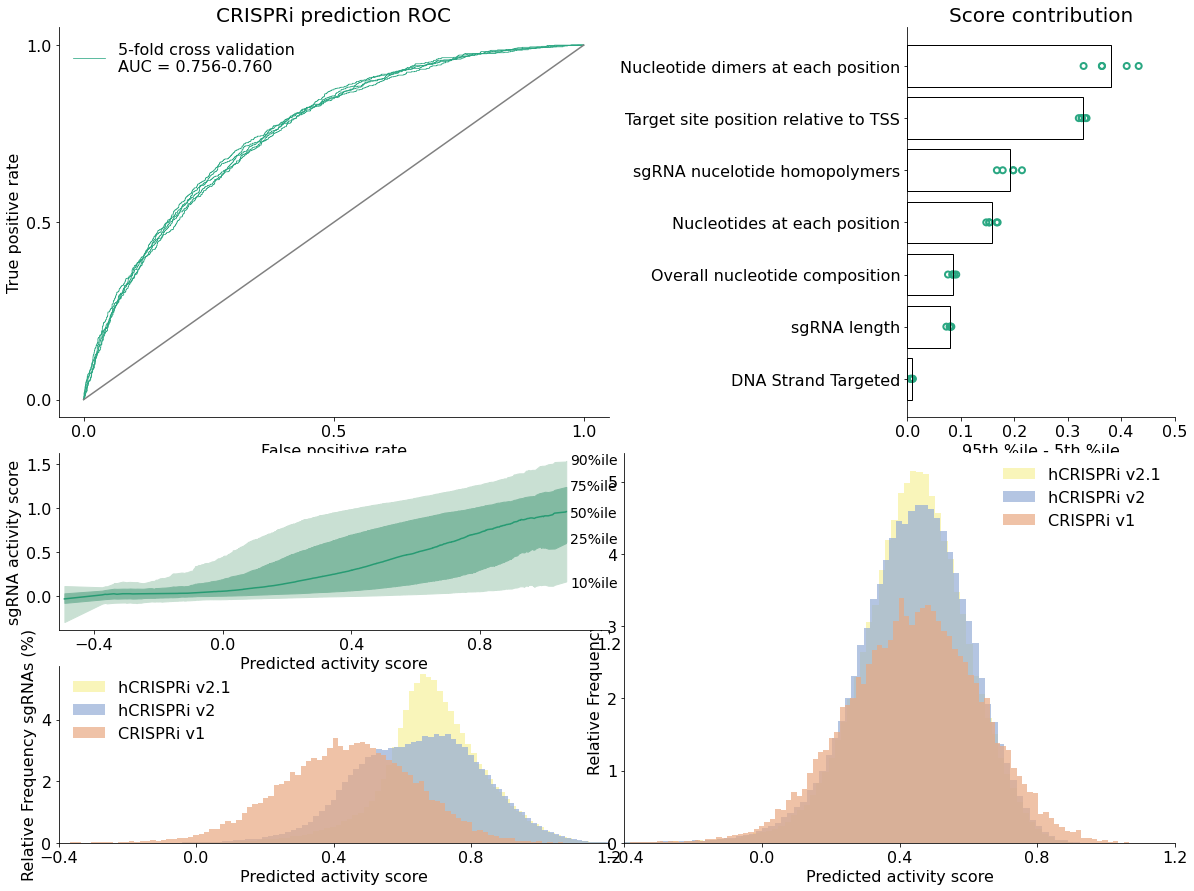

In [159]:
# fig = plt.figure(figsize=(20,15))
# gs = fig.add_gridspec(4, 12)

# # ROC 
# ROC_ax = fig.add_subplot(gs[0:2, 0:6])
# for i in range(len(models)): 
#     test_idxs = splits[i][1]
#     preds_arr = models[i].predict(features_arr_std[test_idxs])
#     scores_bin = scores_arr[test_idxs] > 0.75
#     fpr, tpr, thresholds = metrics.roc_curve(scores_bin, preds_arr)
#     ROC_ax.plot(fpr, tpr, lw=0.75, color="#2AA782", label='5-fold cross validation\nAUC = 0.756-0.760')
#     if i == 0:
#         ROC_ax.legend(frameon=False)
    
# ROC_ax.plot(np.array([0,1]), np.array([0,1]), color="gray")
# ROC_ax.set_xlabel("False positive rate")
# ROC_ax.set_ylabel("True positive rate")
# ROC_ax.set_xticks(np.array([0, 0.5, 1]))
# ROC_ax.set_yticks(np.array([0, 0.5, 1]))
# ROC_ax.set_title("CRISPRi prediction ROC", fontsize=20)

# ROC_ax.spines['top'].set_visible(False)
# ROC_ax.spines['right'].set_visible(False)


# # Feature contribution 
# contr_ax = fig.add_subplot(gs[0:2, 9:12])

# for i in range(len(contrs)):
#     contr_ax.scatter(contrs[i], np.arange(0, len(labels)), lw=2, facecolors='none', edgecolors='#2AA782')

# contr_ax.barh(labels, avg_contrs, color=(1, 1, 1, 0), edgecolor='k')
# contr_ax.set_xlim(0, 0.5)
# contr_ax.set_title('Score contribution', fontsize=20)
# contr_ax.set_xlabel("95th %ile - 5th %ile")

# contr_ax.spines['top'].set_visible(False)
# contr_ax.spines['right'].set_visible(False)

# # Histogram
# their_hist_ax = fig.add_subplot(gs[3:4, 0:6])

# their_hist_ax.set_xlabel("Predicted activity score")
# their_hist_ax.set_ylabel("Relative Frequency sgRNAs (%)")

# their_hist_ax.set_xticks(np.array([-0.4, 0.0, 0.4, 0.8, 1.2]))
# their_hist_ax.set_xlim(-0.4, 1.2)

# their_hist_ax.hist(v2p1_scores, bins=100, color='#f7f29d', alpha=0.7, 
#         weights=(np.zeros_like(v2p1_scores) + 1. / v2p1_scores.size) * 100,
#         label="hCRISPRi v2.1")

# their_hist_ax.hist(v2_scores, bins=100, color='#94add6', alpha=0.7, 
#         weights=(np.zeros_like(v2_scores) + 1. / v2_scores.size) * 100, 
#         label="hCRISPRi v2")

# their_hist_ax.hist(v1_scores, bins=100, color='#e9a982', alpha=0.7, 
#         weights=(np.zeros_like(v1_scores) + 1. / v1_scores.size) * 100, 
#         label="CRISPRi v1")

# their_hist_ax.spines['top'].set_visible(False)
# their_hist_ax.spines['right'].set_visible(False)

# their_hist_ax.legend(frameon=False)

# # Histogram 
# our_hist_ax = fig.add_subplot(gs[2:4, 6:12])

# our_hist_ax.set_xlabel("Predicted activity score")
# our_hist_ax.set_ylabel("Relative Frequency sgRNAs (%)")
# our_hist_ax.set_xticks(np.array([-0.4, 0.0, 0.4, 0.8, 1.2]))
# our_hist_ax.set_xlim(-0.4, 1.2)

# our_hist_ax.hist(v2p1_scores_1, bins=100, color='#f7f29d', alpha=0.7, 
#         weights=(np.zeros_like(v2p1_scores_1) + 1. / v2p1_scores_1.size) * 100, 
#         label="hCRISPRi v2.1")

# our_hist_ax.hist(v2_scores_1, bins=100, color='#94add6', alpha=0.7, 
#         weights=(np.zeros_like(v2_scores_1) + 1. / v2_scores_1.size) * 100, 
#         label="hCRISPRi v2")

# our_hist_ax.hist(v1_scores, bins=100, color='#e9a982', alpha=0.7, 
#         weights=(np.zeros_like(v1_scores) + 1. / v1_scores.size) * 100, 
#         label="CRISPRi v1")

# our_hist_ax.spines['top'].set_visible(False)
# our_hist_ax.spines['right'].set_visible(False)

# our_hist_ax.legend(frameon=False)

# # Predictions vs. Actual

# pred_ax = fig.add_subplot(gs[2:3, 0:6])

# pred_ax.set_xlabel("Predicted activity score")
# pred_ax.set_ylabel("sgRNA activity score")

# pred_ax.set_xticks(np.array([-0.4, 0.0, 0.4, 0.8, 1.2]))
# pred_ax.set_xlim(-0.51, 1.2)

# pred_ax.set_yticks(np.array([0.0, 0.5, 1.0, 1.5]))

# pred_ax.plot(sorted_preds_scores, ile50, color="#279b73")
# pred_ax.fill_between(sorted_preds_scores, ile10, ile90, color="#c9e0d3")
# pred_ax.fill_between(sorted_preds_scores, ile25, ile75, color="#82baa2")

# pred_ax.text(1.08, 1.5, '90%ile', fontsize=14)
# pred_ax.text(1.08, 1.2, '75%ile', fontsize=14)
# pred_ax.text(1.08, 0.9, '50%ile', fontsize=14)
# pred_ax.text(1.08, 0.6, '25%ile', fontsize=14)
# pred_ax.text(1.08, 0.1, '10%ile', fontsize=14)

# pred_ax.spines['top'].set_visible(False)
# pred_ax.spines['right'].set_visible(False)


# fig.tight_layout()
# plt.show()